In [107]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.datasets

from tqdm import trange

In [108]:
data_train = torchvision.datasets.MNIST(root="./mnist_data", train=True, ) # add download=True if you don't have it on disk
data_test = torchvision.datasets.MNIST(root="./mnist_data", train=False) # add download=True if you don't have it on disk
X_train, y_train = data_train.data, data_train.targets
X_test, y_test = data_test.data, data_test.targets

# normalize X_train to [0, 1]
X_train = X_train / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])


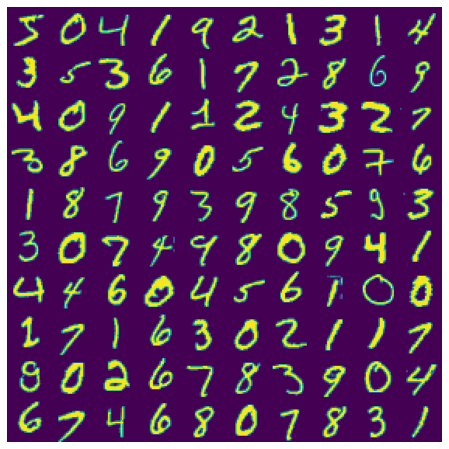

In [109]:
# plot a grid of images
def create_grid(X, n):
    """
    Creates a n-by-n grid from the first n**2 images of dataset X.
    
    args:
        X: np.array shaped (n_obs, height, width) containing images
        n: int: number of images in each row & column of the grid
    
    returns:
        np.array shapoed (n**2, height, width)
    """
    N = n**2
    X_grid = X[:N]
    indices = [(i, i+n) for i in range(0, N, n)]
    grid = np.concatenate(
        [np.concatenate(X_grid[i:j], axis=1) for i, j in indices]
    )
    return grid

grid = create_grid(X=X_train.numpy(), n=10)

plt.figure(figsize=(8, 8))
plt.imshow(grid)
plt.axis("off")
plt.show()

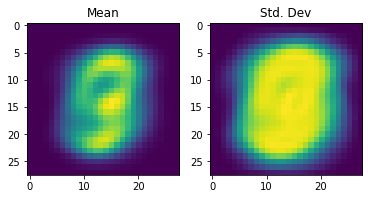

In [110]:
# compute the mean & std for each cell across all training images
#
# The mean image tells you how the average image looks like.
# The std image tells you in what areas we observe the most 
# similarities across images, and in what areas we observe the most
# differences. 
#
# In MNIST, as to be expected, the most similarity across images
# is at the corners, since the handwritten digit is placed somewhere
# in the middle, surrounded by darkness.

mean_img = np.mean(X_train.numpy(), axis=0)
sd_img = np.std(X_train.numpy(), axis=0)

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(mean_img)
plt.title("Mean")
fig.add_subplot(1, 2, 2)
plt.imshow(sd_img)
plt.title("Std. Dev")
plt.show(block=True)

In [124]:
# model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        """
        Args:
            x (torch.array shape[batch_size, height, width]): batch of images
        Returns:
            out (torch.array shape[batch_size, n_classes]): unnormalized scores
        """
        x = x.flatten(start_dim=1)
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        return out
    
net = Net()
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(net.parameters(), lr=0.1)

In [125]:
# Run a single image through the network
x, y = X_train[0], y_train[0]
x = x.reshape((1, *x.shape)) # from shape (28, 28) to (1, 28, 28)
y = y.reshape((-1)) # from shape () to shape (1)
print(x.shape, y.shape)

out = net(x)
probs = nn.functional.softmax(out, dim=1)
loss = crit(out, y)

print(out)
print(probs)
print(loss)

torch.Size([1, 28, 28]) torch.Size([1])
tensor([[ 0.1983,  0.1715,  0.1627, -0.0344, -0.0819, -0.1990, -0.0266,  0.0265,
          0.0719,  0.2700]], grad_fn=<AddmmBackward>)
tensor([[0.1142, 0.1112, 0.1102, 0.0905, 0.0863, 0.0768, 0.0912, 0.0962, 0.1007,
         0.1227]], grad_fn=<SoftmaxBackward>)
tensor(2.5670, grad_fn=<NllLossBackward>)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 744.03it/s]


accuracy: 0.90625


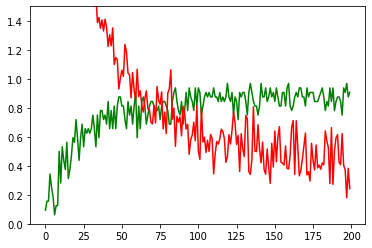

In [126]:
# training
BS = 32
EPOCHS = 200
accuracies = []
losses = []
for i in trange(EPOCHS):
    net.zero_grad()
    
    # draw random batch (mit Zurücklegen)
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp]
    y = y_train[samp]
    
    out = net(X)
    loss = crit(out, y)
    losses.append(loss.item())
    # accuracy
    preds = torch.argmax(out, dim=1)
    acc = (preds == y).float().mean()
    accuracies.append(acc)
    
    
    loss.backward()
    optim.step()
    
print(f"accuracy: {acc}")
plt.plot(accuracies, "g"); plt.plot(losses, "r")
plt.ylim(0, 1.5)
plt.show()

In [127]:
# evaluation
X = X_test.reshape((X_test.shape[0], -1)).float()
out = net(X)
preds = torch.argmax(out, dim=1).numpy()
acc = (preds == y_test.numpy()).mean()
print(acc)

0.8799


## from scratch in numpy

In [128]:
X_train, y_train = X_train.numpy(), y_train.numpy()

In [129]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))